In [79]:
import scipy
import datetime
from sklearn import svm
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import itemgetter, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn import cross_validation
from sklearn import preprocessing
from nltk import word_tokenize    
from nltk.tag import pos_tag  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import json
import pprint
import random
import re
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from scipy.optimize import minimize
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import itertools

### Read the JSON files into a list of dictionaries, with each JSON document read as a dictionary.
def readjson(filename):
    with open(filename) as infile:
        data = json.load(infile)
    return data

### Read train and test data.
train = readjson("data/train.json")
test = readjson("data/test.json")

train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

print (train_df.shape)
print (test_df.shape)

(4040, 32)
(1631, 17)


In [80]:
train_df.groupby(['requester_received_pizza']).size()

requester_received_pizza
False    3046
True      994
dtype: int64

In [81]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [82]:
class_names = ['No-Pizza','Pizza']
def evaluate(classes,y_true,y_pred,normalize):
    print (classification_report(y_true, y_pred))
    plot_confusion_matrix(confusion_matrix(y_true,y_pred), classes=class_names,normalize=normalize,
                      title='Confusion matrix')
    plt.show()

In [83]:
### Double the successes to 'balance' the dataset
train_df_fail = train_df[train_df['requester_received_pizza'] == 0]
print(train_df_fail.shape)
train_df_success = train_df[train_df['requester_received_pizza'] == 1]
print(train_df_success.shape)
train_df = pd.concat([train_df_fail, train_df_success,
                      train_df_success, train_df_success], axis = 0)
train_df.index = range(train_df.shape[0])

# Extract output labels separately for use in training and prediction
# accuracy comparision on dev data.
#train_labels = np.ravel(train_df[['requester_received_pizza']])

(3046, 32)
(994, 32)


In [84]:
def create_features(df):
    # Length of the post's title
    df['title_len'] = df.request_title.str.len()

    # Length of the post's text
    df['request_len'] = df.request_text_edit_aware.str.len()

    # Whether or not the user was subscribed to exactly 0 subreddits
    df['zero_subreddits'] = df['requester_number_of_subreddits_at_request'] == 0

    # Total number of comments + number of random acts of pizza comments
    df['total_comments'] = (df['requester_number_of_comments_in_raop_at_request'] +
                                 df['requester_number_of_comments_at_request'])

    # The ratio of the user's total comments to their number of random acts of pizza comments
    df['comment_ratio'] = (df['total_comments'] /
                                df['requester_number_of_comments_in_raop_at_request'])
    
    df.loc[df['comment_ratio'] == np.inf, 'comment_ratio'] = \
        df.loc[df['comment_ratio'] != np.inf, 'comment_ratio'].mean(skipna = True)
    
    df.loc[pd.isnull(df['comment_ratio']), 'comment_ratio'] = \
        df.loc[pd.notnull(df['comment_ratio']), 'comment_ratio'].mean(skipna = True)

    # The number of upvotes they've received
    df['upvotes'] = (df['requester_upvotes_minus_downvotes_at_request'] +
                       df['requester_upvotes_plus_downvotes_at_request']) / 2

    # The number of downvotes they've received
    df['downvotes'] = (df['requester_upvotes_plus_downvotes_at_request'] -
                             df['upvotes'])
    
    # The ratio of upvotes they've received
    df['upvote_ratio'] = (df['upvotes'] /
                               (df['upvotes'] + df['downvotes']))
    
    df.loc[df['upvote_ratio'] == np.inf, 'upvote_ratio'] = \
        df.loc[df['upvote_ratio'] != np.inf, 'upvote_ratio'].mean(skipna = True)

    df.loc[pd.isnull(df['upvote_ratio']), 'upvote_ratio'] = \
        df.loc[pd.notnull(df['upvote_ratio']), 'upvote_ratio'].mean(skipna = True)

    # Get the date in order to make future variables
    df['date'] = pd.to_datetime(df['unix_timestamp_of_request_utc'], unit = 's')

    # Hour of the post
    df['hour'] = pd.DatetimeIndex(df['date']).hour

    # Day of the post
    df['day'] = pd.DatetimeIndex(df['date']).day

    # The post's day of the week
    df['weekday'] = pd.DatetimeIndex(df['date']).weekday

    # Whether the post was made in the first half of the month
    df['first_half_of_month'] = df['day'] <= 15
    df['first_half_of_month'] = df['first_half_of_month'].astype(int)

    # Whether the post was made on a weekend
    df['weekend'] = (df['weekday'] == 5) | (df['weekday'] == 6)
    df['weekend'] = df['weekend'].astype(int)

    # Whether the post was made in the morning
    df['morning'] = (df['hour'] >= 6) & (df['hour'] < 12)
    df['morning'] = df['morning'].astype(int)

    # Whether the post was made in the afternoon
    df['afternoon'] = (df['hour'] >= 12) & (df['hour'] < 16)
    df['afternoon'] = df['afternoon'].astype(int)

    # Whether the post was made in the evening
    df['evening'] = (df['hour'] >= 16) & (df['hour'] < 20)
    df['evening'] = df['evening'].astype(int)

    # Whether the post was made at night
    df['night'] = (df['hour'] >= 20) & (df['hour'] < 23)
    df['night'] = df['night'].astype(int)

    # Whether the post was made late at night
    df['latenight'] = (df['hour'] >= 23) & (df['hour'] < 6)
    df['latenight'] = df['latenight'].astype(int)

    # Whether there was a difference between the utc and unix timestamp
    df['utcdiff'] = (df['unix_timestamp_of_request_utc'] -
                              df['unix_timestamp_of_request'])

    # Month of the post
    df['month'] = pd.DatetimeIndex(df['date']).month

    # Week of the post
    df['week'] = pd.DatetimeIndex(df['date']).week
    
    # Get the US federal holidays and categorize the request dates as holiday or not.
    cal = USFederalHolidayCalendar()
    holiday_list = cal.holidays(start=df['date'].min(),
                            end=df['date'].max())
    holiday_list = [time.date() for time in holiday_list]

    df['justdate'] = [time.date() for time in df['date']]
    df['holiday'] = df['justdate'].isin(holiday_list)
    df['holiday'] = df['holiday'].astype(int)

    return(df)

train_df = create_features(train_df)
test_df = create_features(test_df)

In [85]:
print (len(train_df.columns))
print (len(test_df.columns))
print (train_df.shape)
print (test_df.shape)

56
41
(6028, 56)
(1631, 41)


In [87]:
test_requests_id=test_df['request_id']

In [78]:
train_data_categorical = train_df[['hour', 'week', 'day', 'weekday', 'month', 'utcdiff']]
test_data_categorical = test_df[['hour', 'week', 'day', 'weekday', 'month', 'utcdiff']]

train_data = train_df.drop(['request_text', 
                            'giver_username_if_known', 'post_was_edited',
                            'request_id', 'request_text_edit_aware',
                            'request_title',
                            'requester_subreddits_at_request',
                            'unix_timestamp_of_request_utc',
                            'unix_timestamp_of_request',
                            'requester_username', 'requester_user_flair',
                            'number_of_downvotes_of_request_at_retrieval',
                            'number_of_upvotes_of_request_at_retrieval',
                            'request_number_of_comments_at_retrieval',
                            'requester_account_age_in_days_at_retrieval',
                            'requester_days_since_first_post_on_raop_at_retrieval',
                            'requester_number_of_comments_at_retrieval',
                            'requester_number_of_comments_in_raop_at_retrieval',
                            'requester_number_of_posts_at_retrieval',
                            'requester_number_of_posts_on_raop_at_retrieval',
                            'requester_upvotes_minus_downvotes_at_retrieval',
                            'requester_upvotes_plus_downvotes_at_retrieval',
                            'date', 'hour', 'week', 'day', 'weekday', 'month', 'utcdiff', 'justdate'
                            ],
                           axis = 1)

test_data = test_df.drop(['giver_username_if_known', 'request_id',
                          'request_text_edit_aware',
                            'request_title',
                            'requester_subreddits_at_request',
                            'unix_timestamp_of_request_utc',
                            'unix_timestamp_of_request',
                            'requester_username',
                            'date', 'hour', 'week', 'day', 'weekday', 'month', 'utcdiff', 'justdate'
                            ],
                           axis = 1)

train_data_dummy = pd.DataFrame(index = train_data.index)
test_data_dummy = pd.DataFrame(index = test_data.index)

for column in train_data_categorical.columns:
    train_data_dummy = pd.concat([train_data_dummy,
                                  pd.get_dummies(train_data_categorical[column],
                                                prefix = column)], axis = 1)    
    test_data_dummy = pd.concat([test_data_dummy,
                                 pd.get_dummies(test_data_categorical[column],
                                                prefix = column)], axis = 1)

train_data = pd.concat([train_data, train_data_dummy], axis = 1)
test_data = pd.concat([test_data, test_data_dummy], axis = 1)

In [32]:
test_data.head(3)
print (train_df.shape)
print (test_df.shape)

(4040, 32)
(1631, 17)


In [13]:
train_data1, dev_data1 = train_test_split(train_data, test_size=0.3)
train_labels = np.ravel(train_data1[['requester_received_pizza']])
train_data1 = train_data1.drop(['requester_received_pizza'],axis = 1)

In [33]:
print (len(train_data1.columns))
print (len(test_data.columns))
train_data1.head(3)
print (train_df.shape)
print (test_df.shape)

154
154
(4040, 32)
(1631, 17)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

y=train_labels
X=train_data1
clf = RandomForestClassifier(n_estimators=300,max_features='sqrt',max_depth=80,min_samples_leaf=1,bootstrap=True,min_samples_split=11)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
dev_data1.head(4)
dev_labels = np.ravel(dev_data1[['requester_received_pizza']])
dev_data1 = dev_data1.drop(['requester_received_pizza'],axis = 1)

In [17]:
X_test=dev_data1
y_test=dev_labels
y_pred = clf.predict(X_test)
print('Accuracy of classifier on dev set: {:.2f}'.format(clf.score(X_test, y_test)))
print('LogLoss : {score}'.format(score=log_loss(y_test, y_pred)))

Accuracy of classifier on dev set: 0.87
LogLoss : 4.639615805586442


             precision    recall  f1-score   support

      False       0.92      0.81      0.86       936
       True       0.82      0.93      0.87       873

avg / total       0.87      0.87      0.87      1809



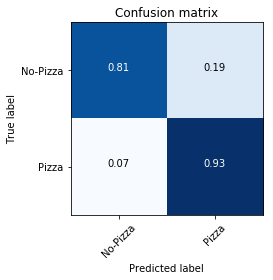

0.8676865803154463


In [21]:
evaluate(class_names,dev_labels,y_pred,True)
print (metrics.roc_auc_score(y_test, y_pred))

In [22]:
print ("dev_data1.shape : " +str(dev_data1.shape))
print ("train_data1.shape : "+ str(train_data1.shape))

dev_data1.shape : (1809, 154)
train_data1.shape : (4219, 154)


In [102]:
print (set(dev_data1.columns))

{'utcdiff_-28800.0', 'week_14', 'day_28', 'week_22', 'week_35', 'day_7', 'week_12', 'week_8', 'week_28', 'week_6', 'weekday_0', 'hour_19', 'month_3', 'day_17', 'day_4', 'day_21', 'week_37', 'week_13', 'weekday_5', 'week_3', 'weekday_2', 'upvotes', 'week_40', 'day_31', 'hour_17', 'week_47', 'week_41', 'week_2', 'holiday', 'month_10', 'comment_ratio', 'week_9', 'week_34', 'day_10', 'hour_3', 'requester_number_of_comments_in_raop_at_request', 'month_5', 'week_31', 'hour_9', 'zero_subreddits', 'utcdiff_-3600.0', 'weekday_1', 'week_27', 'hour_10', 'week_17', 'month_8', 'day_11', 'week_39', 'hour_13', 'week_45', 'requester_number_of_subreddits_at_request', 'week_23', 'day_8', 'upvote_ratio', 'month_1', 'week_16', 'month_11', 'month_6', 'hour_22', 'weekday_4', 'day_29', 'hour_11', 'week_15', 'requester_number_of_posts_on_raop_at_request', 'day_1', 'day_5', 'day_27', 'hour_12', 'afternoon', 'night', 'week_5', 'day_9', 'downvotes', 'day_18', 'week_21', 'week_48', 'week_38', 'first_half_of_month

In [66]:
len(train_data1.columns)

154

In [68]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0,solver='lbfgs',C=0.21,
multi_class='multinomial',class_weight='balanced').fit(X, y)

In [69]:
X_test=dev_data1
y_test=dev_labels
y_pred = clf.predict(X_test)
print('Accuracy of classifier on dev set: {:.2f}'.format(clf.score(X_test, y_test)))
print('LogLoss : {score}'.format(score=log_loss(y_test, y_pred)))

Accuracy of classifier on dev set: 0.56
LogLoss : 15.045238064284236


             precision    recall  f1-score   support

      False       0.56      0.62      0.59       916
       True       0.57      0.51      0.54       893

avg / total       0.56      0.56      0.56      1809



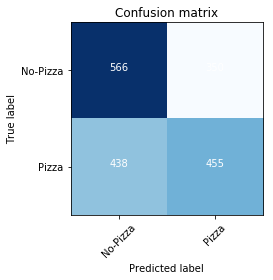

0.5637112035873386


In [70]:
evaluate(class_names,dev_labels,y_pred)
print (metrics.roc_auc_score(y_test, y_pred))

In [25]:
train_data.shape

(6028, 155)

In [23]:
X_test=test_data
y_pred_test = clf.predict(X_test)

In [37]:
y_pred_test

array([False, False, False, ..., False,  True, False])

In [40]:
prediction_df=pd.DataFrame(data=y_pred_test,  columns=['prediction'])

In [57]:
prediction_df.to_csv("raop.csv",index=False)

In [47]:
clf.n_features_ 

154

In [41]:
prediction_df.groupby(['prediction']).size()

prediction
False    1236
True      395
dtype: int64

In [44]:
clf.feature_importances_

array([0.04423558, 0.01986808, 0.03061309, 0.01527192, 0.03154524,
       0.00594415, 0.03192189, 0.0385223 , 0.04250529, 0.0514214 ,
       0.08700255, 0.00149053, 0.03080666, 0.01607843, 0.04146527,
       0.03580213, 0.03790068, 0.00636307, 0.00627277, 0.0035468 ,
       0.0052965 , 0.00698575, 0.00659887, 0.        , 0.00203342,
       0.0049991 , 0.00463781, 0.00399333, 0.00393715, 0.00428692,
       0.00310659, 0.00154018, 0.00102699, 0.00046121, 0.00100442,
       0.00051689, 0.00052092, 0.00118311, 0.00161026, 0.00282893,
       0.00292833, 0.00384031, 0.00372529, 0.00517027, 0.00456785,
       0.0039819 , 0.0054873 , 0.00520918, 0.00497189, 0.002774  ,
       0.00111804, 0.00107699, 0.00123513, 0.00134155, 0.00175556,
       0.00073837, 0.00251673, 0.0027101 , 0.00174896, 0.00194525,
       0.00131304, 0.00205551, 0.00196551, 0.00152584, 0.00200497,
       0.00199536, 0.00223785, 0.00132683, 0.00167345, 0.00195946,
       0.00171456, 0.00307339, 0.00197087, 0.00197686, 0.00670

In [46]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [52]:
for name, importance in sorted(zip(train_data1.columns, clf.feature_importances_), key=lambda tup: tup[1], reverse=True):
    print(name, "=", importance)

request_len = 0.08700254897963942
title_len = 0.05142140058188229
requester_account_age_in_days_at_request = 0.04423558138851493
requester_upvotes_plus_downvotes_at_request = 0.04250529074678999
upvotes = 0.04146527398870305
requester_upvotes_minus_downvotes_at_request = 0.03852230116119236
upvote_ratio = 0.0379006794830789
downvotes = 0.03580213325609154
requester_number_of_subreddits_at_request = 0.031921890871941506
requester_number_of_posts_at_request = 0.031545243472190704
total_comments = 0.030806663902747868
requester_number_of_comments_at_request = 0.030613087634934644
requester_days_since_first_post_on_raop_at_request = 0.019868082648239766
comment_ratio = 0.016078425219193813
requester_number_of_comments_in_raop_at_request = 0.015271920070320398
month_7 = 0.0093834455182544
weekday_2 = 0.007123664985535137
evening = 0.0069857535543843274
weekday_0 = 0.006855104067767631
month_6 = 0.0067176723955358775
week_26 = 0.006704907658975401
night = 0.006598866215873154
weekday_3 = 0.0

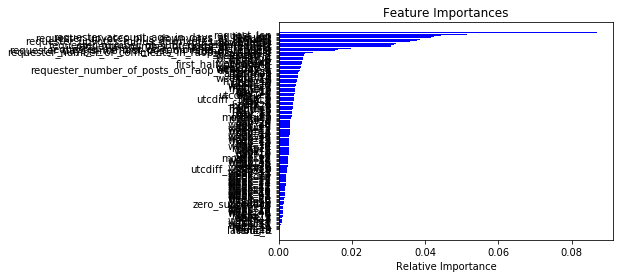

In [49]:
features = train_data1.columns
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [58]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=11,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [64]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split': [5,6,7,8,8,9, 10,11, 12],
    'n_estimators': [300, 350, 400]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='roc_auc')

In [65]:
grid_search.fit(train_data1, train_labels)

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_fe

[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto, total=   3.0s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto 


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   59.1s


[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.0s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.2s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=80, min_samples_leaf=1, max_features=auto, total=   2.4s
[CV] bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=80, min_samples_leaf=2, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=80, min_samples_leaf=2, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=80, min_samples_leaf=2, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=2, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=auto, total=   3.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=auto, total=   3.0s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=auto, total=   3.1s
[CV] bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_esti

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.7min


[CV]  bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=80, min_samples_leaf=2, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=2, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=2, max_features=auto, total=   2.8s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=2, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estima

[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=3, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=3, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=3, max_features=auto, total=   2.0s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=3, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=4

[CV]  bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=80, min_samples_leaf=3, max_features=auto, total=   1.8s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=80, min_samples_leaf=3, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=80, min_samples_leaf=3, max_features=auto, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=80, min_samples_leaf=3, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=80, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=80, min_samples_leaf=4, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=80, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=80, min_samples_leaf=4, max_features=auto, total=   1.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=80, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=80, min_samples_leaf=4, max_features=auto, total=   1.7s
[CV] bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=80, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=80, min_samples_leaf=4, max_features=auto, total=   1.8s
[CV] bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=80, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=80, min_samples_leaf=4, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=80, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=80, min_samples_leaf=4, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=80, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=80, min_samples_leaf=4, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=80, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=80, min_samples_leaf=4, max_features=auto, total=   1.8s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=80, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimato

[CV]  bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=6, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=4

[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  8.1min


[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.8s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.0s
[CV] bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.0s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=sqrt, total=   2.0s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=80, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=80, min_samples_leaf=2, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=80, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=80, min_samples_leaf=2, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=80, min_samples_leaf=2, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=2, max_features=sqrt, total=   2.0s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=80, min_samples_leaf=2, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=80, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=300, min_samples_split=6, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   4.0s
[CV] bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=80, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   3.0s
[CV] bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=80, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   3.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=80, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   3.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=80, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=4

[CV]  bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   3.2s
[CV] bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=80, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   2.5s
[CV] bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=80, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=80, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   3.0s
[CV] bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=80, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=3, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   2.1s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators

[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   3.9s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   4.0s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   3.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   3.3s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   3.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   3.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_esti

[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 15.7min


[CV]  bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   3.2s
[CV] bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   3.8s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=80, min_samples_leaf=4, max_features=sqrt, total=   3.2s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estima

[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=auto, total=   3.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=auto, total=   3.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=auto, total=   3.2s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=4

[CV]  bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=90, min_samples_leaf=1, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=90, min_samples_leaf=1, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=90, min_samples_leaf=1, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=90, min_samples_leaf=1, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=90, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=90, min_samples_leaf=2, max_features=auto, total=   3.0s
[CV] bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=90, min_samples_leaf=2, max_features=auto, total=   3.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=90, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=90, min_samples_leaf=2, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=90, min_samples_leaf=2, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=auto, total=   1.8s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimato

[CV]  bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=90, min_samples_leaf=3, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=90, min_samples_leaf=3, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=90, min_samples_leaf=3, max_features=auto, total=   3.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=90, min_samples_leaf=3, max_features=auto, total=   3.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=6, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=4

[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=3, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=3, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=3, max_features=auto, total=   2.9s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=3, max_features=auto, total=   3.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=4

[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=auto, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=auto, total=   2.8s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=90, min_samples_leaf=4, max_features=auto, total=   3.1s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=90, min_samples_leaf=4, max_features=auto, total=   2.8s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=auto, total=   1.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=auto, total=   1.7s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=90, min_samples_leaf=4, max_features=auto, total=   3.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=4, max_features=auto, total=   3.2s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=4, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=4, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=4

[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed: 24.7min


[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   2.8s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   3.5s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   3.0s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   3.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=90, min_samples_leaf=1, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=90, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=sqrt, total=   3.0s
[CV] bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=sqrt, total=   3.0s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=90, min_samples_leaf=2, max_features=sqrt, total=   3.2s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=2, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=sqrt, total=   2.5s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=sqrt, total=   5.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=90, min_samples_leaf=2, max_features=sqrt, total=   5.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=90, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=300, min_samples_split=6, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   1.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=90, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=90, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=90, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=90, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=4

[CV]  bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   2.1s
[CV] bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=90, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   2.0s
[CV] bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=90, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=90, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   2.8s
[CV] bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=90, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=90, min_samples_leaf=3, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   1.8s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators

[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   2.8s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   2.9s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=3

[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   2.5s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   2.5s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=sqrt, total=   3.0s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=90, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=100, min_samples_leaf=1, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=100, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=100, min_samples_leaf=1, max_features=auto, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=100, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=100, min_samples_leaf=1, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=100, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=100, min_samples_leaf=1, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=100, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=100, min_samples_leaf=1, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=100, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=100, min_samples_leaf=1, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=100, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=100, min_samples_leaf=1, max_features=auto, total=   2.1s
[CV] bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=100, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=100, min_samples_leaf=1, max_features=auto, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=100, min_samples_leaf=1, max_features=auto 
[CV]  bootstrap=True,

[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=2, max_features=auto, total=   4.5s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=2, max_features=auto, total=   4.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=6, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=2, max_features=auto, total=   4.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=6, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=6, max_depth=100, min_samples_leaf=2, max_features=auto, total=   3.3s
[CV] bootstrap=True, n_estim

[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estim

[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto 


[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 35.3min


[CV]  bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto, total=   3.0s
[CV] bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.8s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=100, min_samples_leaf=2, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, 

[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=3, max_features=auto, total=   2.4s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=3, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=3, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=3, max_features=auto, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=100, min_samples_leaf=3, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=100, min_samples_leaf=3, max_features=auto, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=100, min_samples_leaf=3, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=100, min_samples_leaf=3, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=100, min_samples_leaf=3, max_features=auto 
[CV]  bootstrap=True

[CV]  bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=100, min_samples_leaf=4, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=100, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=100, min_samples_leaf=4, max_features=auto, total=   2.0s
[CV] bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=100, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=100, min_samples_leaf=4, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=100, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=7, max_depth=100, min_samples_leaf=4, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=7, max_depth=100, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_esti

[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=100, min_samples_leaf=4, max_features=auto, total=   2.6s
[CV] bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=100, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=100, min_samples_leaf=4, max_features=auto, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=100, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=9, max_depth=100, min_samples_leaf=4, max_features=auto, total=   2.4s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=100, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=100, min_samples_leaf=4, max_features=auto, total=   1.9s
[CV] bootstrap=True, n_estimators=300, min_samples_split=10, max_depth=100, min_samples_leaf=4, max_features=auto 
[CV]  bootstrap=True, n_

[CV] bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   3.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   3.1s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   3.3s
[CV] bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=5, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   2.8s
[CV] bootstrap=True, n_estim

[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=8, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   2.5s
[CV] bootstrap=True, n_estim

[CV] bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   2.1s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=12, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   2.1s
[CV] bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=100, min_samples_leaf=1, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=12, max_depth=100, min_samples_leaf=1, max_features=sqrt, total=   2.4s
[CV] bootstrap=True,

[CV] bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=100, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=100, min_samples_leaf=2, max_features=sqrt, total=   2.8s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=7, max_depth=100, min_samples_leaf=2, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=sqrt, total=   2.1s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=100, min_samples_leaf=2, max_features=sqrt, total=   2.0s
[CV] bootstrap=True, n_estim

[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=100, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=10, max_depth=100, min_samples_leaf=2, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=100, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=100, min_samples_leaf=2, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=100, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=100, min_samples_leaf=2, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estimators=300, min_samples_split=11, max_depth=100, min_samples_leaf=2, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=10, max_depth=100, min_samples_leaf=2, max_features=sqrt, total=   2.7s
[CV] bootstrap=True,

[CV] bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=100, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=100, min_samples_leaf=3, max_features=sqrt, total=   2.3s
[CV] bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=100, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=100, min_samples_leaf=3, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=100, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=6, max_depth=100, min_samples_leaf=3, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=100, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=6, max_depth=100, min_samples_leaf=3, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estim

[CV] bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=100, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=100, min_samples_leaf=3, max_features=sqrt, total=   1.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=100, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=9, max_depth=100, min_samples_leaf=3, max_features=sqrt, total=   1.9s
[CV] bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=100, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=100, min_samples_leaf=3, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=100, min_samples_leaf=3, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=9, max_depth=100, min_samples_leaf=3, max_features=sqrt, total=   2.2s
[CV] bootstrap=True, n_estim

[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=12, max_depth=100, min_samples_leaf=3, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   2.1s
[CV] bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   2.6s
[CV] bootstrap=True, n_estimators=350, min_samples_split=5, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=5, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   3.0s
[CV] bootstrap=True, n_esti

[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   2.7s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=8, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   2.5s
[CV] bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=300, min_samples_split=8, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   1.9s
[CV] bootstrap=True, n_estim

[CV] bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=350, min_samples_split=11, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   2.4s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   2.8s
[CV] bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=100, min_samples_leaf=4, max_features=sqrt 
[CV]  bootstrap=True, n_estimators=400, min_samples_split=11, max_depth=100, min_samples_leaf=4, max_features=sqrt, total=   2.9s
[CV] bootstrap=True,

[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed: 46.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'n_estimators': [300, 350, 400], 'min_samples_split': [5, 6, 7, 8, 8, 9, 10, 11, 12], 'max_depth': [80, 90, 100], 'min_samples_leaf': [1, 2, 3, 4], 'max_features': ['auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [66]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 350}

             precision    recall  f1-score   support

      False       0.93      0.84      0.88       936
       True       0.84      0.93      0.89       873

avg / total       0.89      0.89      0.88      1809



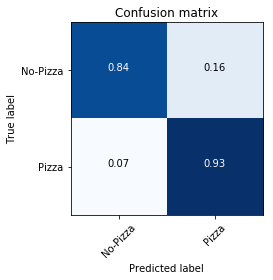

0.8866915587276412


In [97]:
X_test=dev_data1
y_test=dev_labels
best_grid_random = grid_search.best_estimator_
y_pred = best_grid_random.predict(X_test)
evaluate(class_names,dev_labels,y_pred,True)
print (metrics.roc_auc_score(y_test, y_pred))

In [88]:
y_pred=best_grid_random.predict(test_data)
#X_test = vectorizer.transform(test_data_text)
#predictions.append(gs_clf.predict_proba(X_test))

In [89]:
x = np.array(y_pred).reshape(-1,1)
final_df = pd.DataFrame.from_records(x,columns=['requester_received_pizza'])

In [91]:
test_requests_id.shape

(1631,)

In [92]:
final_df=final_df.join(test_requests_id)
cols = final_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
final_df = final_df[cols]
final_df.requester_received_pizza=final_df.requester_received_pizza.astype(int)

In [93]:
final_df.groupby(['requester_received_pizza']).size()

requester_received_pizza
0    1308
1     323
dtype: int64

In [94]:
final_df.head(1)

,request_id,requester_received_pizza
0,t3_i8iy4,0


In [95]:
final_df.to_csv('final_submission.csv',header=True,index=False)

In [96]:
!pwd

/w205/a_final_project
